# Gaussian or lognormal?


Within a species, the distribution of many measurements is well modeled by a Gaussian distribution.
But for some measurements a lognormal distribution is a better fit.
For some measurements both models fit well, and for others, neither does.

These observations suggest several questions we might want to answer:

* Why might these distributions follow either model?

* Why do some fit a Gaussian and others a lognormal?

* How can we best determine which is a better fit.

I address the first two questions in Chapters 1 and 4 of *Probably Overthinking It*.
This notebook addresses the third, by suggesting a way to fit these models to an observed dataset and to evaluate the fit.

As examples, I'll use two datasets:

* The Anthropometric Survey of US Army Personnel (ANSUR II), available from [the Open Design Lab at Penn State](https://www.openlab.psu.edu/).

* Results of medical blood tests from [supplemental material](https://www.degruyter.com/document/doi/10.1515/labmed-2020-0005/html) from "Quantitative laboratory results: normal or lognormal distribution?" by Frank Klawonn , Georg Hoffmann and Matthias Orth.

The following cells install packages and download the files we'll need.

In [1]:
# install empiricaldist if we don't already have it

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [2]:
# download utils.py

from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download(
    "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/notebooks/utils.py"
)

In [3]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import decorate

%load_ext nb_black

<IPython.core.display.Javascript object>

## ANSUR Data

The ANSUR dataset contains 93 measurements from 4082 male and 1986 female members of the U.S. armed forces.


In [4]:
download(
    "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/data/ANSURIIFEMALEPublic.csv"
)
download(
    "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/data/ANSURIIMALEPublic.csv"
)

<IPython.core.display.Javascript object>

In [5]:
ansur_female = pd.read_csv("ANSURIIFEMALEPublic.csv", encoding="ISO-8859-1")
ansur_female.shape

(1986, 108)

<IPython.core.display.Javascript object>

In [6]:
ansur_male = pd.read_csv("ANSURIIMALEPublic.csv", encoding="ISO-8859-1")
ansur_male.shape

(4082, 108)

<IPython.core.display.Javascript object>

In [7]:
ansur_male.columns

Index(['subjectid', 'abdominalextensiondepthsitting', 'acromialheight',
       'acromionradialelength', 'anklecircumference', 'axillaheight',
       'balloffootcircumference', 'balloffootlength', 'biacromialbreadth',
       'bicepscircumferenceflexed',
       ...
       'Branch', 'PrimaryMOS', 'SubjectsBirthLocation', 'SubjectNumericRace',
       'Ethnicity', 'DODRace', 'Age', 'Heightin', 'Weightlbs',
       'WritingPreference'],
      dtype='object', length=108)

<IPython.core.display.Javascript object>

The measurements are the columns in all lowercase.

In [8]:
measurements = [column for column in ansur_female.columns if column.lower() == column]
measurements

['abdominalextensiondepthsitting',
 'acromialheight',
 'acromionradialelength',
 'anklecircumference',
 'axillaheight',
 'balloffootcircumference',
 'balloffootlength',
 'biacromialbreadth',
 'bicepscircumferenceflexed',
 'bicristalbreadth',
 'bideltoidbreadth',
 'bimalleolarbreadth',
 'bitragionchinarc',
 'bitragionsubmandibulararc',
 'bizygomaticbreadth',
 'buttockcircumference',
 'buttockdepth',
 'buttockheight',
 'buttockkneelength',
 'buttockpopliteallength',
 'calfcircumference',
 'cervicaleheight',
 'chestbreadth',
 'chestcircumference',
 'chestdepth',
 'chestheight',
 'crotchheight',
 'crotchlengthomphalion',
 'crotchlengthposterioromphalion',
 'earbreadth',
 'earlength',
 'earprotrusion',
 'elbowrestheight',
 'eyeheightsitting',
 'footbreadthhorizontal',
 'footlength',
 'forearmcenterofgriplength',
 'forearmcircumferenceflexed',
 'forearmforearmbreadth',
 'forearmhandlength',
 'functionalleglength',
 'handbreadth',
 'handcircumference',
 'handlength',
 'headbreadth',
 'headcir

<IPython.core.display.Javascript object>

In [9]:
len(measurements)

93

<IPython.core.display.Javascript object>

The following function takes a `Series` and finds a Gaussian distribution that uses a [soft L1 norm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html) to minimize the area between the data and the model.

In [10]:
from empiricaldist import Cdf
from scipy.optimize import least_squares
from scipy.stats import norm


def fit_model(series, verbose=False):
    """Find the model that minimizes the errors in percentiles."""

    def error_func(params):
        error = np.abs(ps - norm.cdf(qs, *params))
        if verbose:
            print(params, np.sum(error))
        return error

    x0 = series.mean(), series.std()
    low, high = series.quantile([0.01, 0.99])

    cdf = Cdf.from_seq(series)
    qs = np.linspace(low, high)
    ps = cdf(qs)

    res = least_squares(error_func, x0=x0, xtol=1e-3, loss="soft_l1")
    assert res.success
    mu, sigma = res.x
    return norm(mu, sigma)

<IPython.core.display.Javascript object>

In [11]:
series = ansur_male["stature"]
dist = fit_model(series, verbose=True)

[1756.21460069   68.55078767] 0.1821344487296781
[1756.21462686   68.55078767] 0.18213631155601778
[1756.21460069   68.55078869] 0.18213448100538832
[1755.57429829   68.2097861 ] 0.1548211165158396
[1755.57432445   68.2097861 ] 0.15482069994677106
[1755.57429829   68.20978712] 0.15482109146464754


<IPython.core.display.Javascript object>

This function computes the area between curves in terms of the average error in percentile points.

In [12]:
def average_error(series):
    """Area between a CDF and a Gaussian model.

    series: sequence of numbers
    """
    dist = fit_model(series)
    cdf = Cdf.from_seq(series)

    low, high = series.quantile([0.01, 0.99])
    qs = np.linspace(low, high)

    error = cdf(qs) - dist.cdf(qs)
    return np.mean(np.abs(error)) * 100

<IPython.core.display.Javascript object>

In [13]:
average_error(series)

0.3096422330316792

<IPython.core.display.Javascript object>

In [14]:
def make_plot(series, **options):
    """Plot the CDF of a series with a Gaussian model.

    series: sequence of numbers
    """
    dist = fit_model(series)
    cdf = Cdf.from_seq(series)
    qs = cdf.index
    ps = dist.cdf(qs)

    plt.fill_between(qs, ps, cdf.values, color="gray", alpha=0.4)
    cdf.plot(lw=1, **options)
    decorate(ylabel="CDF")

<IPython.core.display.Javascript object>

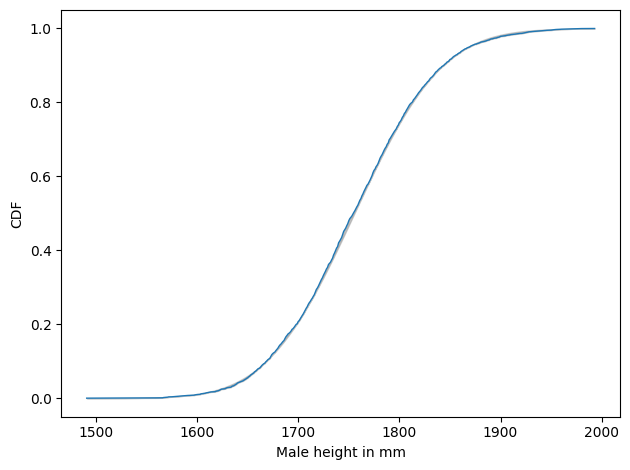

<IPython.core.display.Javascript object>

In [15]:
make_plot(series)
decorate(xlabel="Male height in mm")

In [16]:
def all_errors(df, tag, measurements, log=False):
    """ """
    res = []

    for varname in measurements:
        series = df[varname]
        if log:
            series = np.log10(series)
        area = average_error(series)
        res.append((area, tag, varname))

    return pd.DataFrame(res, columns=["error", "sex", "measurement"])

<IPython.core.display.Javascript object>

In [17]:
res_female = all_errors(ansur_female, "female", measurements)
res_male = all_errors(ansur_male, "male", measurements)

gaussian = pd.concat([res_female, res_male])

<IPython.core.display.Javascript object>

In [18]:
res_female_log = all_errors(ansur_female, "female", measurements, log=True)
res_male_log = all_errors(ansur_male, "male", measurements, log=True)

lognormal = pd.concat([res_female_log, res_male_log])

<IPython.core.display.Javascript object>

In [19]:
def join(gaussian, lognormal):
    """ """
    joined = gaussian.merge(
        lognormal, on=["measurement", "sex"], suffixes=("_gaussian", "_lognormal")
    )
    joined["diff"] = joined["error_gaussian"] - joined["error_lognormal"]
    joined["sum"] = joined["error_gaussian"] + joined["error_lognormal"]
    return joined

<IPython.core.display.Javascript object>

In [20]:
joined = join(gaussian, lognormal)

<IPython.core.display.Javascript object>

In [21]:
def scatterplot(joined):
    """ """
    high1 = joined["error_gaussian"].max()
    high2 = joined["error_lognormal"].max()
    high = max(high1, high2) * 1.05
    xs = np.linspace(0, high)

    plt.plot(xs, xs + 0.5, color="gray", alpha=0.4)
    plt.plot(xs, xs - 0.5, color="gray", alpha=0.4)
    plt.text(0.1, 2, "Gaussian better")
    plt.text(1.8, 0.2, "lognormal better")

    plt.plot(joined["error_gaussian"], joined["error_lognormal"], "o", alpha=0.4)
    decorate(
        xlabel="Average error in percentiles, Gaussian",
        ylabel="Average error in percentiles, lognormal",
        xlim=[0, high],
        ylim=[0, high],
    )

<IPython.core.display.Javascript object>

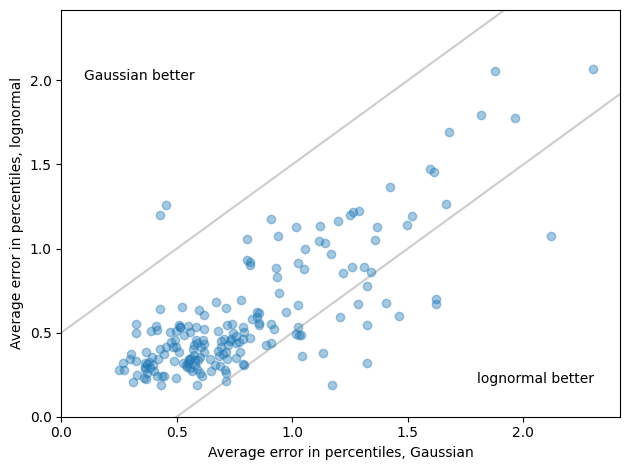

<IPython.core.display.Javascript object>

In [22]:
scatterplot(joined)
plt.savefig("log_vs_normal5.png", dpi=300)

In [23]:
joined.sort_values(by="diff", inplace=True)

<IPython.core.display.Javascript object>

In [24]:
def make_double_plot(series, xlabel=""):
    """Plot Gaussian and lognormal models for a given Series

    series: sequence of numbers
    xlabel: string label for the x-axis

    """
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    make_plot(series, label="Gaussian")
    decorate(ylabel="Percentile Rank", xlabel=xlabel)

    plt.subplot(1, 2, 2)
    make_plot(np.log10(series), label="lognormal")
    decorate(xlabel=xlabel + " (log10)")

    plt.tight_layout()

<IPython.core.display.Javascript object>

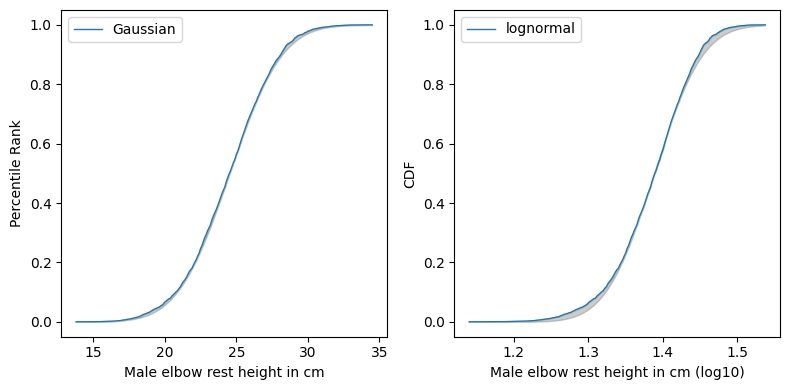

<IPython.core.display.Javascript object>

In [25]:
# Gaussian better

series = ansur_male["elbowrestheight"] / 10
make_double_plot(series, "Male elbow rest height in cm")
plt.savefig("log_vs_normal1.png", dpi=300)

In [26]:
joined.tail()

,error_gaussian,sex,measurement,error_lognormal,diff,sum
180,1.620303,male,waistdepth,0.702878,0.917425,2.323182
0,1.623475,female,abdominalextensiondepthsitting,0.667677,0.955798,2.291152
183,1.170825,male,weightkg,0.189704,0.981121,1.360530
90,1.322391,female,weightkg,0.319606,1.002785,1.641997
87,2.120735,female,waistdepth,1.077030,1.043705,3.197765


<IPython.core.display.Javascript object>

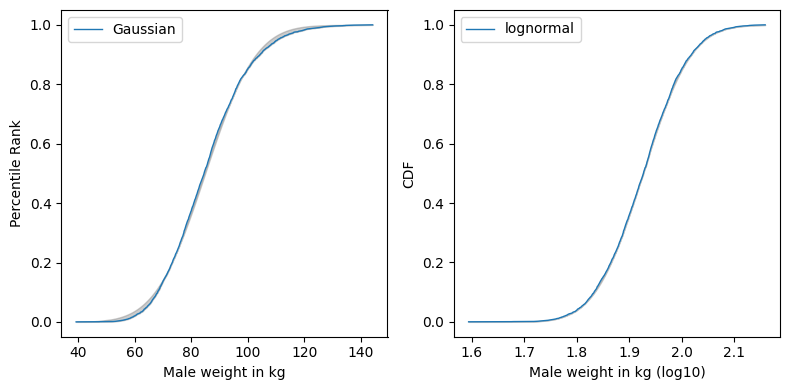

<IPython.core.display.Javascript object>

In [27]:
# lognormal better

series = ansur_male["weightkg"] / 10
make_double_plot(series, "Male weight in kg")
plt.savefig("log_vs_normal2.png", dpi=300)

In [28]:
joined.sort_values(by="sum", inplace=True)
joined.head()

,error_gaussian,sex,measurement,error_lognormal,diff,sum
167,0.309642,male,stature,0.206610,0.103032,0.516253
185,0.250212,male,wristheight,0.275790,-0.025578,0.526002
156,0.271811,male,overheadfingertipreachsitting,0.275191,-0.003380,0.547002
97,0.327813,male,axillaheight,0.246388,0.081426,0.574201
163,0.266334,male,sittingheight,0.320184,-0.053850,0.586517


<IPython.core.display.Javascript object>

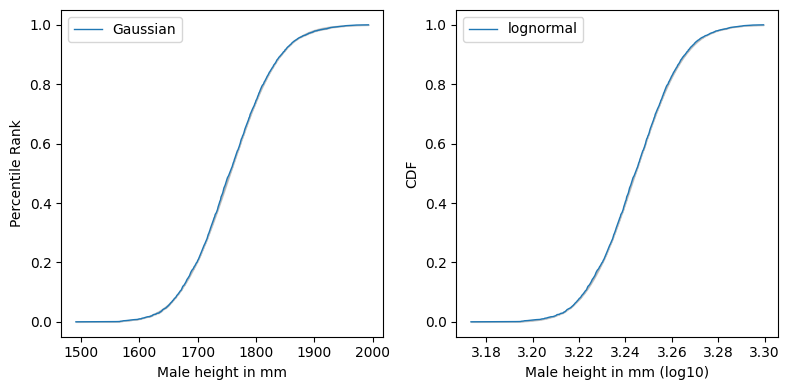

<IPython.core.display.Javascript object>

In [29]:
# both good

series = ansur_male["stature"]
make_double_plot(series, "Male height in mm")
plt.savefig("log_vs_normal3.png", dpi=300)

In [30]:
joined.tail()

,error_gaussian,sex,measurement,error_lognormal,diff,sum
122,1.676438,male,earbreadth,1.692780,-0.016342,3.369218
11,1.816925,female,bimalleolarbreadth,1.795962,0.020964,3.612887
124,1.965292,male,earprotrusion,1.773712,0.191580,3.739004
29,1.879525,female,earbreadth,2.053329,-0.173804,3.932854
31,2.303347,female,earprotrusion,2.067253,0.236094,4.370600


<IPython.core.display.Javascript object>

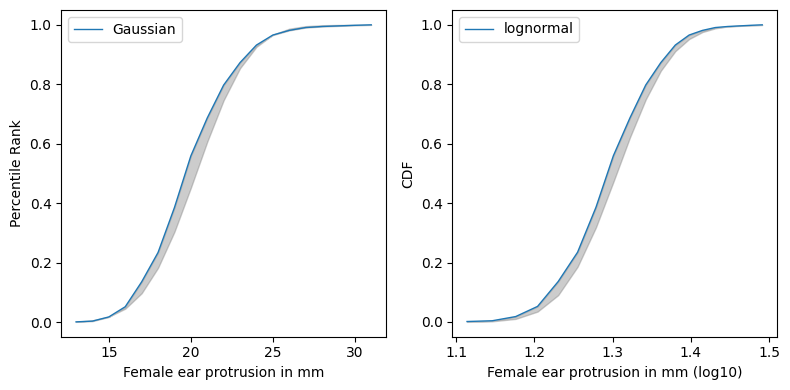

<IPython.core.display.Javascript object>

In [31]:
# both bad

series = ansur_female["earprotrusion"]
make_double_plot(series, "Female ear protrusion in mm")
plt.savefig("log_vs_normal4.png", dpi=300)

## Lab Results



In [32]:
download(
    "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/data/Test_Data_JLM.csv"
)

<IPython.core.display.Javascript object>

In [33]:
lab = pd.read_csv("Test_Data_JLM.csv")
lab.head()

,Na,Hb,K,Crea,WBC,ALAT,sex
0,139,153,3.6,86,16.50,42,m
1,136,134,3.7,72,4.67,36,m
2,140,140,4.1,83,15.10,19,m
3,138,159,4.0,86,19.90,22,m
4,138,167,4.3,72,6.76,38,m


<IPython.core.display.Javascript object>

In [34]:
varnames = ["Na", "Hb", "K", "Crea", "WBC", "ALAT"]

<IPython.core.display.Javascript object>

In [35]:
male = lab["sex"] == "m"
female = lab["sex"] == "f"
male.sum(), female.sum()

(1000, 1000)

<IPython.core.display.Javascript object>

In [36]:
varnames = ["Hb", "WBC", "Na", "K", "Crea", "ALAT"]
labels = [
    "Hb (g/L)",
    "WBC (cells/nL)",
    "Na (mmol/L)",
    "K (mmol/L)",
    "Crea ($\mu$mol/L)",
    "ALAT (U/L)",
]
label_dict = dict(zip(varnames, labels))

<IPython.core.display.Javascript object>

In [37]:
res_male = all_errors(lab[male], "male", varnames, log=False)
res_female = all_errors(lab[female], "female", varnames, log=False)
gaussian = pd.concat([res_male, res_female])

<IPython.core.display.Javascript object>

In [38]:
res_male_log = all_errors(lab[male], "male", varnames, log=True)
res_female_log = all_errors(lab[female], "female", varnames, log=True)
lognormal = pd.concat([res_male_log, res_female_log])

<IPython.core.display.Javascript object>

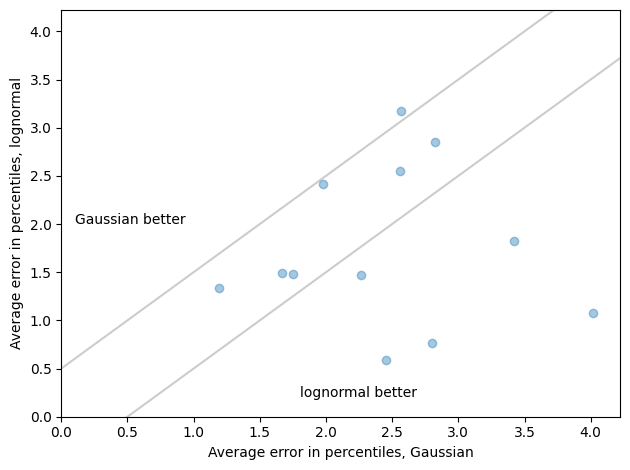

<IPython.core.display.Javascript object>

In [39]:
joined = join(gaussian, lognormal)
scatterplot(joined)

In [40]:
(joined["diff"] > 0).mean()

0.6666666666666666

<IPython.core.display.Javascript object>

In [41]:
joined.sort_values(by="diff", inplace=True)
joined.head(3)

,error_gaussian,sex,measurement,error_lognormal,diff,sum
6,2.569561,female,Hb,3.168235,-0.598674,5.737797
0,1.976727,male,Hb,2.415662,-0.438935,4.392390
10,1.191881,female,Crea,1.335989,-0.144108,2.527870


<IPython.core.display.Javascript object>

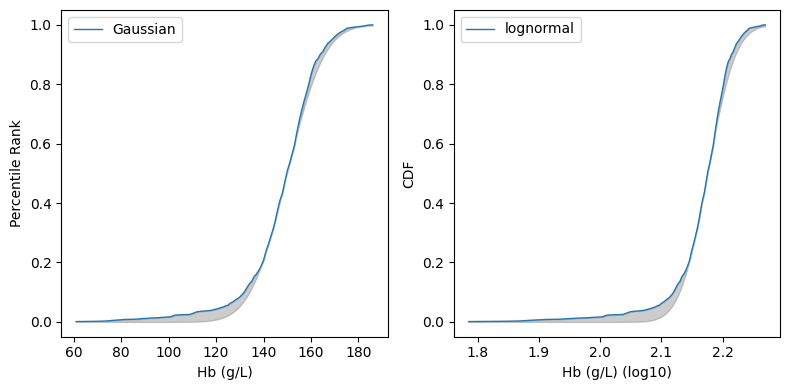

<IPython.core.display.Javascript object>

In [42]:
# Gaussian better (but both bad)

name = "Hb"
make_double_plot(lab.loc[male, name], label_dict[name])

In [43]:
joined.tail()

,error_gaussian,sex,measurement,error_lognormal,diff,sum
4,2.267264,male,Crea,1.466140,0.801124,3.733404
11,3.419685,female,ALAT,1.826160,1.593525,5.245845
7,2.454356,female,WBC,0.586840,1.867516,3.041196
1,2.800216,male,WBC,0.767287,2.032929,3.567503
5,4.020443,male,ALAT,1.079603,2.940840,5.100046


<IPython.core.display.Javascript object>

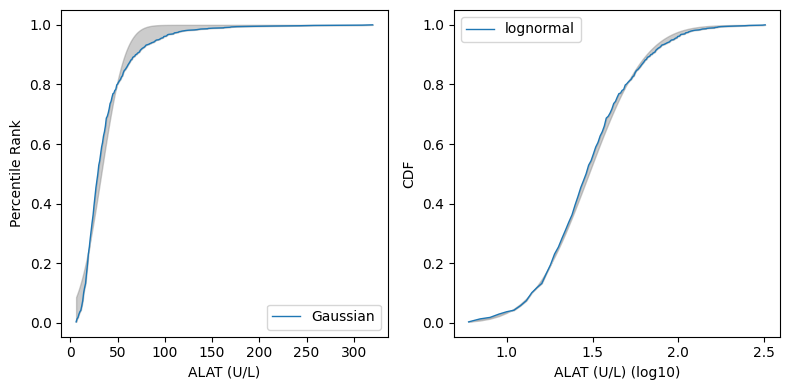

<IPython.core.display.Javascript object>

In [44]:
# lognormal better

name = "ALAT"
make_double_plot(lab.loc[male, name], label_dict[name])

In [45]:
joined.sort_values(by="sum", inplace=True)
joined.head()

,error_gaussian,sex,measurement,error_lognormal,diff,sum
10,1.191881,female,Crea,1.335989,-0.144108,2.527870
7,2.454356,female,WBC,0.586840,1.867516,3.041196
9,1.670563,female,K,1.487594,0.182969,3.158158
3,1.751536,male,K,1.486174,0.265362,3.237710
1,2.800216,male,WBC,0.767287,2.032929,3.567503


<IPython.core.display.Javascript object>

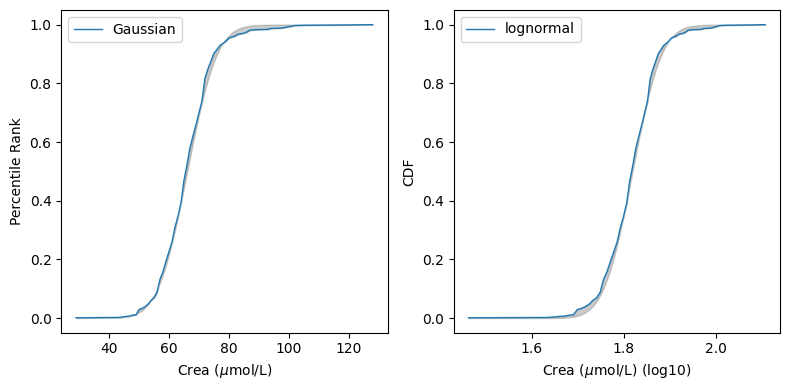

<IPython.core.display.Javascript object>

In [46]:
# Both good

name = "Crea"
make_double_plot(lab.loc[female, name], label_dict[name])

In [47]:
joined.tail()

,error_gaussian,sex,measurement,error_lognormal,diff,sum
5,4.020443,male,ALAT,1.079603,2.940840,5.100046
8,2.558988,female,Na,2.551349,0.007639,5.110336
11,3.419685,female,ALAT,1.826160,1.593525,5.245845
2,2.826943,male,Na,2.850049,-0.023105,5.676992
6,2.569561,female,Hb,3.168235,-0.598674,5.737797


<IPython.core.display.Javascript object>

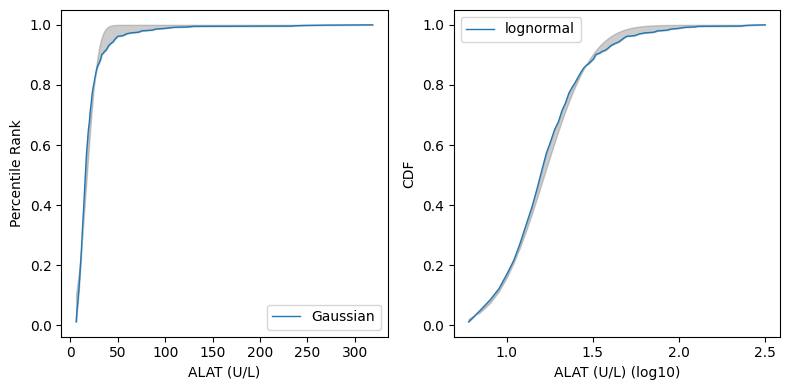

<IPython.core.display.Javascript object>

In [48]:
# both bad (but lognormal better)

name = "ALAT"
make_double_plot(lab.loc[female, name], label_dict[name])

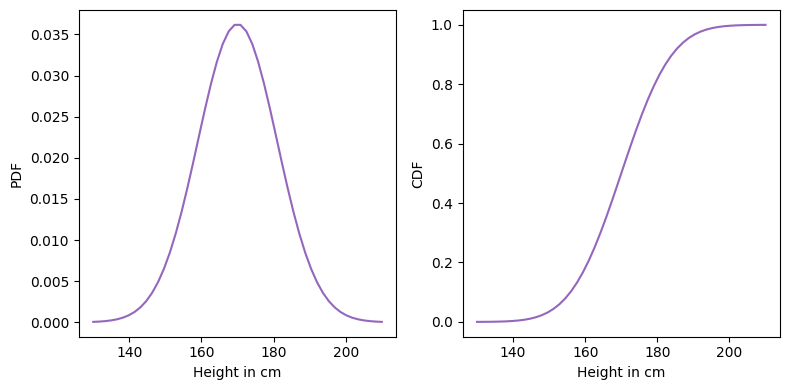

<IPython.core.display.Javascript object>

In [49]:
dist = norm(170, 11)
xs = np.linspace(130, 210)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
ps = dist.pdf(xs)
plt.plot(xs, ps, color="C4")
decorate(ylabel="PDF", xlabel="Height in cm")

plt.subplot(1, 2, 2)
ps = dist.cdf(xs)
plt.plot(xs, ps, color="C4")
decorate(ylabel="CDF", xlabel="Height in cm")

plt.tight_layout()
plt.savefig("log_vs_normal10.png", dpi=300)

Here's a version of the model-fitting code that's easier to walk through.

In [59]:
from empiricaldist import Cdf

cdf_data = Cdf.from_seq(series)

low, high = series.quantile([0.01, 0.99])
qs = np.linspace(low, high)
ps = cdf_data(qs)

<IPython.core.display.Javascript object>

In [55]:
from scipy.stats import norm


def error_func(params):
    print(params)
    cdf_model = norm(*params).cdf
    error = cdf_model(qs) - cdf_data(qs)
    return error

<IPython.core.display.Javascript object>

In [56]:
from scipy.optimize import least_squares


def fit_model(series):
    x0 = series.mean(), series.std()
    res = least_squares(error_func, x0=x0, xtol=1e-3, loss="soft_l1")
    return res.x

<IPython.core.display.Javascript object>

In [57]:
series = ansur_male["stature"]
fit_model(series)

[1756.21460069   68.55078767]
[1756.21462686   68.55078767]
[1756.21460069   68.55078869]
[1755.57429829   68.2097861 ]
[1755.57432445   68.2097861 ]
[1755.57429829   68.20978712]


array([1755.57429829,   68.2097861 ])

<IPython.core.display.Javascript object>

Probably Overthinking It: The Puzzles and Paradoxes of Probability

Copyright 2022 Allen Downey 

